# Solving Quadratic Programming Models
## Mehmet Gönen
## December 7, 2022

In [1]:
# load libraries
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as sp
import scipy.linalg as linalg

import cplex as cp

In [2]:
def quadratic_programming(direction, A, senses, b, c, Q, l, u):
    # create an empty optimization problem
    prob = cp.Cplex()

    # add decision variables to the problem including their linear coefficients in objective and ranges
    prob.variables.add(obj = c.tolist(), lb = l.tolist(), ub = u.tolist())
    
    # add quadratic coefficients in objective
    row_indices, col_indices = Q.nonzero()
    prob.objective.set_quadratic_coefficients(zip(row_indices.tolist(), col_indices.tolist(), Q.data.tolist()))

    # define problem type
    if direction == "maximize":
        prob.objective.set_sense(prob.objective.sense.maximize)
    else:
        prob.objective.set_sense(prob.objective.sense.minimize)

    # add constraints to the problem including their directions and right-hand side values
    prob.linear_constraints.add(senses = senses.tolist(), rhs = b.tolist())

    # add coefficients for each constraint
    row_indices, col_indices = A.nonzero()
    prob.linear_constraints.set_coefficients(zip(row_indices.tolist(), col_indices.tolist(), A.data.tolist()))

    print(prob.write_as_string())
    # solve the problem
    prob.solve()

    # check the solution status
    print(prob.solution.get_status())
    print(prob.solution.status[prob.solution.get_status()])

    # get the solution
    x_star = prob.solution.get_values()
    obj_star = prob.solution.get_objective_value()

    return(x_star, obj_star)

## Euclidean distance between polyhedra
Let $C$ and $D$ be two polyhedra described by the sets of linear inequalities $\mathbf{A}_{1} \boldsymbol{x} \leq \boldsymbol{b}_{1}$ and $\mathbf{A}_{2} \boldsymbol{x} \leq \boldsymbol{b}_{2}$, respectively. The distance between $C$ and $D$ is the distance between the closest pair of points, one in $C$ and the other in $D$, as illustrated in figure below.

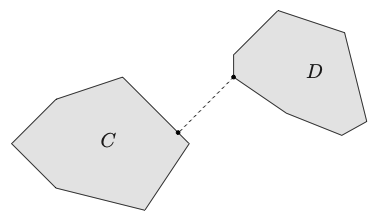

The distance between them is the optimal value of the problem

\begin{align*}
\mbox{minimize} \;\;& \|\boldsymbol{x}_{1} - \boldsymbol{x}_{2}\|_{2} = \sqrt{(x_{11} - x_{21})^{2} + (x_{12} - x_{22})^{2}} \\
\mbox{subject to:} \;\;& \mathbf{A}_{1} \boldsymbol{x}_{1} \leq  \boldsymbol{b}_{1}\\
\;\;& \mathbf{A}_{2} \boldsymbol{x}_{2} \leq  \boldsymbol{b}_{2}.
\end{align*}

We can square the objective to obtain an equivalent QP.

\begin{align*}
\mbox{minimize} \;\;& \|\boldsymbol{x}_{1} - \boldsymbol{x}_{2}\|_{2}^{2} = (x_{11} - x_{21})^{2} + (x_{12} - x_{22})^{2} = x_{11}^2 - 2 x_{11} x_{21} + x_{21}^{2} + x_{12}^2 - 2 x_{12} x_{22} + x_{22}^{2} \\
\mbox{subject to:} \;\;& \mathbf{A}_{1} \boldsymbol{x}_{1} \leq  \boldsymbol{b}_{1}\\
\;\;& \mathbf{A}_{2} \boldsymbol{x}_{2} \leq  \boldsymbol{b}_{2}.
\end{align*}

\begin{align*}
\mbox{minimize} \;\;& \begin{bmatrix}x_{11} & x_{12} & x_{21} & x_{22}\end{bmatrix}
\begin{bmatrix} 1 & 0 & -1 & 0\\0 & 1 & 0 & -1\\-1 & 0 & 1 & 0\\0 & -1 & 0 & 1\end{bmatrix}
\begin{bmatrix}x_{11} \\ x_{12} \\ x_{21} \\ x_{22}\end{bmatrix}\\
\mbox{subject to:} \;\;& \begin{bmatrix} \mathbf{A}_{1} & \mathbf{0} \\ \mathbf{0} & \mathbf{A}_{2} \end{bmatrix} \begin{bmatrix}x_{11} \\ x_{12} \\ x_{21} \\ x_{22}\end{bmatrix} \leq \begin{bmatrix} \boldsymbol{b}_{1} \\ \boldsymbol{b}_{2}\end{bmatrix}.
\end{align*}

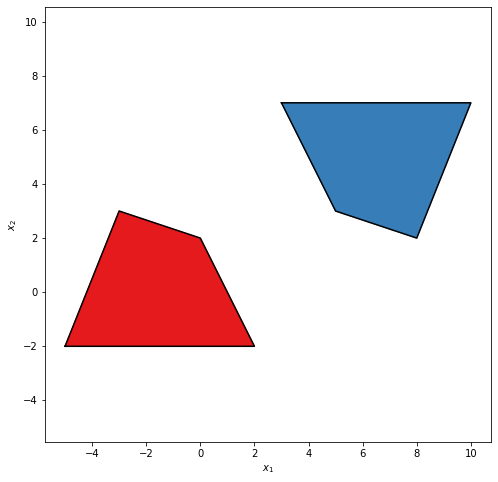

In [3]:
plt.figure(figsize = (8, 8))
plt.axis("equal")
plt.fill([3, 10, 8, 5], [7, 7, 2, 3], color = "#377eb8")
plt.plot([3, 10, 8, 5, 3], [7, 7, 2, 3, 7], color = "black")
plt.fill([-5, 2, 0, -3], [-2, -2, 2, 3], color = "#e41a1c")
plt.plot([-5, 2, 0, -3, -5], [-2, -2, 2, 3, -2], color = "black")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.show()

The blue polyhedron can be represented as

\begin{align*}
\underbrace{\begin{bmatrix} 0 & 1\\5 & -2\\-1 & -3\\-2 & -1\end{bmatrix}}_{\mathbf{A}_{1}} \underbrace{\begin{bmatrix} x_{11}\\x_{12}\end{bmatrix}}_{\boldsymbol{x}_{1}} \leq \underbrace{\begin{bmatrix} 7\\36\\-14\\-13\end{bmatrix}}_{\boldsymbol{b}_{1}}.
\end{align*}

The red polyhedron can be represented as

\begin{align*}
\underbrace{\begin{bmatrix} 0 & -1\\2 & 1\\1 & 3\\-5 & 2\end{bmatrix}}_{\mathbf{A}_{2}} \underbrace{\begin{bmatrix} x_{21}\\x_{22}\end{bmatrix}}_{\boldsymbol{x}_{2}} \leq \underbrace{\begin{bmatrix} 2\\2\\6\\21\end{bmatrix}}_{\boldsymbol{b}_{2}}.
\end{align*}

In [4]:
A1 = np.array([[0, 1],
               [5, -2],
               [-1, -3],
               [-2, -1]])

b1 = np.array([7, 36, -14, -13])

A2 = np.array([[0, -1],
               [2, 1],
               [1, 3],
               [-5, 2]])

b2 = np.array([2, 2, 6, 21])

In [5]:
c = np.repeat(0, 4)
senses = np.repeat("L", A1.shape[0] + A2.shape[0])
b = np.concatenate((b1, b2))
l = np.repeat(-cp.infinity, 4)
u = np.repeat(cp.infinity, 4)

A = np.vstack((np.hstack((A1, np.zeros((A1.shape[0], 2)))),
               np.hstack((np.zeros((A2.shape[0], 2)), A2))))
A = sp.csr_matrix(A)

Q = 2 * np.array([[1, 0, -1, 0],
                  [0, 1, 0, -1],
                  [-1, 0, 1, 0],
                  [0, -1, 0, 1]])
Q = sp.csr_matrix(Q)

x_star, obj_star = quadratic_programming("minimize", A, senses, b, c, Q, l, u)
print(x_star)
print(obj_star)

Default variable names x1, x2 ... being created.
Default row names c1, c2 ... being created.


\ENCODING=ISO-8859-1
\Problem name: 

Minimize
 obj1: [ 2 x1 ^2 - 4 x1 * x3 + 2 x2 ^2 - 4 x2 * x4 + 2 x3 ^2 + 2 x4 ^2 ] / 2
Subject To
 c1: x2 <= 7
 c2: 5 x1 - 2 x2 <= 36
 c3: - x1 - 3 x2 <= -14
 c4: - 2 x1 - x2 <= -13
 c5: - x4 <= 2
 c6: 2 x3 + x4 <= 2
 c7: x3 + 3 x4 <= 6
 c8: - 5 x3 + 2 x4 <= 21
Bounds
      x1 Free
      x2 Free
      x3 Free
      x4 Free
End

Version identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
Number of nonzeros in lower triangle of Q = 2
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.00 ticks)
Summary statistics for factor of Q:
  Rows in Factor            = 4
  Integer space required    = 4
  Total non-zeros in factor = 6
  Total FP ops to factor    = 10
Tried aggregator 1 time.
QP Presolve eliminated 4 rows and 2 columns.
QP Presolve added 0 rows and 4 columns.
Reduced QP has 8 rows, 6 columns, and 18 nonzeros.
Reduced QP objective Q matrix has 2 nonzeros.
Presolve 

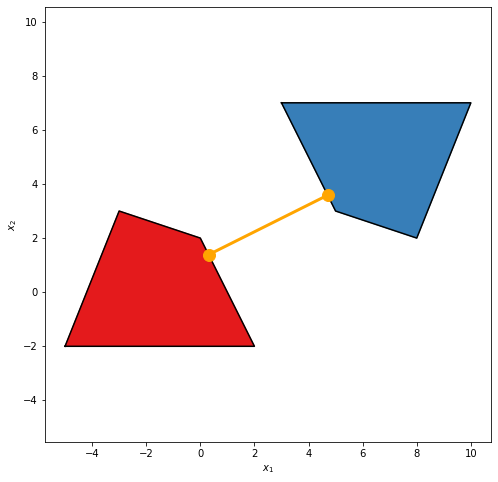

In [6]:
plt.figure(figsize = (8, 8))
plt.axis("equal")
plt.fill([3, 10, 8, 5], [7, 7, 2, 3], color = "#377eb8")
plt.plot([3, 10, 8, 5, 3], [7, 7, 2, 3, 7], color = "black")
plt.fill([-5, 2, 0, -3], [-2, -2, 2, 3], color = "#e41a1c")
plt.plot([-5, 2, 0, -3, -5], [-2, -2, 2, 3, -2], color = "black")
plt.plot(x_star[0], x_star[1], "o", color = "orange", markersize = 12)
plt.plot(x_star[2], x_star[3], "o", color = "orange", markersize = 12)
plt.plot([x_star[0], x_star[2]], [x_star[1], x_star[3]], color = "orange", linewidth = 3)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.show()

In [7]:
def distance_between_polyhedra(A1, b1, A2, b2):
    N = A1.shape[1]
    M1 = A1.shape[0]
    M2 = A2.shape[0]
    c = np.repeat(0, 2 * N)
    senses = np.repeat("L", M1 + M2)
    b = np.concatenate((b1, b2))
    l = np.repeat(-cp.infinity, 2 * N)
    u = np.repeat(cp.infinity, 2 * N)

    A = linalg.block_diag(A1, A2)
    A = sp.csr_matrix(A)

    Q = sp.diags((2, -2, -2), offsets = (0, N, -N), shape = (2 * N, 2 * N), format = "csr")

    x_star, obj_star = quadratic_programming("minimize", A, senses, b, c, Q, l, u)
    return(x_star[:-N], x_star[N:], np.sqrt(obj_star))

In [8]:
print(A1)
print(b1)
print(A2)
print(b2)
x1, x2, distance = distance_between_polyhedra(A1, b1, A2, b2)
print(x1)
print(x2)
print(distance)

Default variable names x1, x2 ... being created.
Default row names c1, c2 ... being created.


[[ 0  1]
 [ 5 -2]
 [-1 -3]
 [-2 -1]]
[  7  36 -14 -13]
[[ 0 -1]
 [ 2  1]
 [ 1  3]
 [-5  2]]
[ 2  2  6 21]
\ENCODING=ISO-8859-1
\Problem name: 

Minimize
 obj1: [ 2 x1 ^2 - 4 x1 * x3 + 2 x2 ^2 - 4 x2 * x4 + 2 x3 ^2 + 2 x4 ^2 ] / 2
Subject To
 c1: x2 <= 7
 c2: 5 x1 - 2 x2 <= 36
 c3: - x1 - 3 x2 <= -14
 c4: - 2 x1 - x2 <= -13
 c5: - x4 <= 2
 c6: 2 x3 + x4 <= 2
 c7: x3 + 3 x4 <= 6
 c8: - 5 x3 + 2 x4 <= 21
Bounds
      x1 Free
      x2 Free
      x3 Free
      x4 Free
End

Version identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
Number of nonzeros in lower triangle of Q = 2
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.00 ticks)
Summary statistics for factor of Q:
  Rows in Factor            = 4
  Integer space required    = 4
  Total non-zeros in factor = 6
  Total FP ops to factor    = 10
Tried aggregator 1 time.
QP Presolve eliminated 4 rows and 2 columns.
QP Presolve added 0 rows and 4 columns.


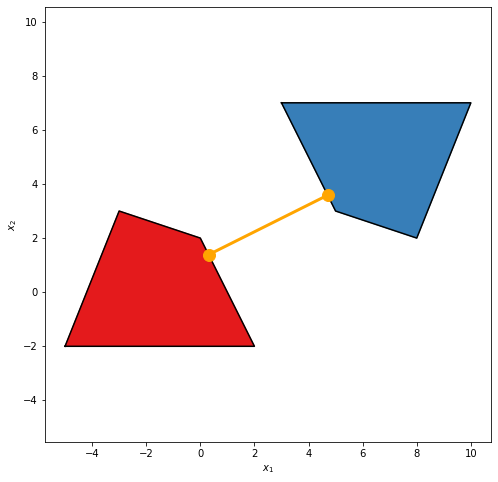

In [9]:
plt.figure(figsize = (8, 8))
plt.axis("equal")
plt.fill([3, 10, 8, 5], [7, 7, 2, 3], color = "#377eb8")
plt.plot([3, 10, 8, 5, 3], [7, 7, 2, 3, 7], color = "black")
plt.fill([-5, 2, 0, -3], [-2, -2, 2, 3], color = "#e41a1c")
plt.plot([-5, 2, 0, -3, -5], [-2, -2, 2, 3, -2], color = "black")
plt.plot(x1[0], x1[1], "o", color = "orange", markersize = 12)
plt.plot(x2[0], x2[1], "o", color = "orange", markersize = 12)
plt.plot([x1[0], x2[0]], [x1[1], x2[1]], color = "orange", linewidth = 3)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.show()

In [10]:
A1 = np.loadtxt("A1.txt")
b1 = np.loadtxt("b1.txt")
A2 = np.loadtxt("A2.txt")
b2 = np.loadtxt("b2.txt")
print(A1)
print(b1)
print(A2)
print(b2)

[[ -3.  11.  19.]
 [ -6.  12.  19.]
 [ 13. -16.  -5.]
 [ 16.  -4. -16.]
 [-12.   4.  15.]
 [  6.  -6.  10.]]
[ 10.  -7. -17. -19.   8. -17.]
[[ -9. -13.  -8.]
 [  3.  -3.  -9.]
 [  3.   0. -17.]
 [  1.  -7. -10.]
 [ -6. -16.  -8.]
 [-13. -20.  -4.]
 [  8.   3.   6.]]
[-12.  -1.  -1.  13.   2.   2.   3.]


In [11]:
x1, x2, distance = distance_between_polyhedra(A1, b1, A2, b2)
print(x1)
print(x2)
print(distance)

Default variable names x1, x2 ... being created.
Default row names c1, c2 ... being created.


\ENCODING=ISO-8859-1
\Problem name: 

Minimize
 obj1: [ 2 x1 ^2 - 4 x1 * x4 + 2 x2 ^2 - 4 x2 * x5 + 2 x3 ^2 - 4 x3 * x6
       + 2 x4 ^2 + 2 x5 ^2 + 2 x6 ^2 ] / 2
Subject To
 c1:  - 3 x1 + 11 x2 + 19 x3 <= 10
 c2:  - 6 x1 + 12 x2 + 19 x3 <= -7
 c3:  13 x1 - 16 x2 - 5 x3 <= -17
 c4:  16 x1 - 4 x2 - 16 x3 <= -19
 c5:  - 12 x1 + 4 x2 + 15 x3 <= 8
 c6:  6 x1 - 6 x2 + 10 x3 <= -17
 c7:  - 9 x4 - 13 x5 - 8 x6 <= -12
 c8:  3 x4 - 3 x5 - 9 x6 <= -1
 c9:  3 x4 - 17 x6 <= -1
 c10: x4 - 7 x5 - 10 x6 <= 13
 c11: - 6 x4 - 16 x5 - 8 x6 <= 2
 c12: - 13 x4 - 20 x5 - 4 x6 <= 2
 c13: 8 x4 + 3 x5 + 6 x6 <= 3
Bounds
      x1 Free
      x2 Free
      x3 Free
      x4 Free
      x5 Free
      x6 Free
End

Version identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
Number of nonzeros in lower triangle of Q = 3
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.01 sec. (0.00 ticks)
Summary statistics for factor of Q:
  Rows in Factor   